In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
import os
for dirname, _, filenames in os.walk('/Users/jeongseohyeon/Downloads/digit-recognizer/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/Users/jeongseohyeon/Downloads/digit-recognizer/test.csv
/Users/jeongseohyeon/Downloads/digit-recognizer/SNN.ipynb
/Users/jeongseohyeon/Downloads/digit-recognizer/train.csv
/Users/jeongseohyeon/Downloads/digit-recognizer/sample_submission.csv


## Spiking neural net

In [3]:
class Brain():
    def __init__(self, n_neurons=100, n_inputs=10, n_outputs=10, n_connections=10,
                 low=-1, resting=0, threshold=1, peak=5, decay=0.5, seed=2020):
        """ Create a brain with hidden, input, and output neurons
            Args: 
            - n_neurons [int]: total number of neurons
            - n_inputs [int]: number of neurons having input
            - n_outputs [int]: number of neurons having output
            - n_connections [int]: number of connections per neuron
            - low: minimum potential of neuron
            - resting: resting potential of neuron
            - threshold: threshold potential of neuron
            - peak: peak fire potential (action potential) of neuron
            - decay [float]: decay rate of neuron potential
            - seed [int]: random seed for numpy
            Return: Brain object
        """
        assert n_neurons >= n_outputs + n_inputs
        assert n_neurons >= n_connections
        self.n_neurons = n_neurons
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_connections = n_connections
        self.low = low
        self.resting = resting     
        self.threshold = threshold
        self.peak = peak
        self.decay = decay
        np.random.seed(seed)
        self.mask = self.generate_mask()
        self.initialize_weights()
        self.initialize_neurons()        

    def generate_mask(self):
        """ Determine how the neurons are connected. It will try to generate on average n_connections per neurons.
            No self-connection are allowed.
        """
        threshold = (self.n_connections + 1) / self.n_neurons
        return (np.random.rand(self.n_neurons, self.n_neurons) < threshold) & ~np.identity(self.n_neurons, dtype='bool')
    
    def initialize_weights(self, seed=None):
        """ Initialize the weights of conected neurons to be between -1 and 1. """
        if seed:
            np.random.seed(seed)
        self.weights = (2 * np.random.rand(self.n_neurons, self.n_neurons).astype('float32') - 1) * self.mask
    
    def initialize_neurons(self):
        self.neurons = np.ones(self.n_neurons).astype('float32') * self.resting  # potentials of the neurons
        self.neurons_fire = np.zeros(self.n_neurons, dtype='bool')               # whether the neurons fires or not
    
    def forward_pass(self):
        # compute input potential
        neurons_next = np.dot(self.weights, self.neurons_fire * self.peak) + self.decay * self.neurons
        # If the neuron has just fired, then suppress its potential to the lowest potential
        neurons_next = np.where(self.neurons_fire, self.low, neurons_next)
        neurons_next = np.clip(neurons_next, a_min=self.low, a_max=None)
        # If input potential (x) is greater than threshold, then fire at peak potential, otherwise no change.
        self.neurons = neurons_next
        self.neurons_fire = self.neurons >= self.threshold
    
    def train_hebbian_one_step(self, learning_rate=0.05):
        """ Train with Hebbian like method (unsupervised learning)
            dW_ij = lr * (next_fire_i * M_ij * prev_fire_j - prev_fire_i * M_ij * next_fire_j)
                  = lr * M_ij * (next_fire_i * prev_fire_j - prev_fire_i * next_fire_j)
        """
        prev_fire = self.neurons_fire
        self.forward_pass()
        next_fire = self.neurons_fire
        # dW = learning_rate * next_fire.reshape(-1, 1) * self.weights * next_fire
        dW = learning_rate * self.mask * (
            next_fire.reshape(-1, 1) * prev_fire - 1 * prev_fire.reshape(-1, 1) * next_fire
        )
        self.weights = np.clip(self.weights + dW, a_min=-1, a_max=1)
    
    def set_inputs(self, inputs):
        self.neurons[:self.n_inputs] = inputs / self.decay
    
    def get_outputs(self):
        return self.neurons[self.n_inputs : self.n_inputs + self.n_outputs]
    
    def predict(self, inputs, steps=10, constant_input=False):
        self.set_inputs(inputs)
        for step in range(steps):
            if constant_input: 
                self.set_inputs(inputs)
            self.forward_pass()
        return self.get_outputs()
    
    def predict_history(self, inputs, steps=10, constant_input=False):
        self.set_inputs(inputs)
        hist = np.zeros((steps, self.n_outputs), dtype='float32')
        for step in range(steps):
            if constant_input: 
                self.set_inputs(inputs)
            self.forward_pass()
            hist[step] = self.get_outputs()
        return hist

    def predict_brain_history(self, inputs, steps=10, constant_input=False):
        self.set_inputs(inputs)
        hist = np.zeros((steps, self.n_neurons), dtype='float32')
        for step in range(steps):
            if constant_input: 
                self.set_inputs(inputs)
            self.forward_pass()
            hist[step] = self.neurons
        return hist
    
    def train_hebbian_brain_history(self, inputs, steps=10, lr=0.05, constant_input=False):
        self.set_inputs(inputs)
        hist = np.zeros((steps, self.n_neurons), dtype='float32')
        for step in range(steps):
            if constant_input: 
                self.set_inputs(inputs)
            self.train_hebbian_one_step(lr)
            hist[step] = self.neurons
        return hist
    
    def train_hebbian_brain_batch(self, X, total_steps=1000, steps_per_sample=10, lr=0.05, constant_input=True):
        """ Train Hebbian brain with an array of data X """
        n_samples_train = np.ceil(total_steps / steps_per_sample).astype('int')
        total_steps = n_samples_train * steps_per_sample
        if n_samples_train > len(X):
            X = np.vstack([X] * np.ceil(n_samples_train / len(X)).astype('int'))
        X = X[:n_samples_train]
        print('training steps:', n_samples_train, 'x', steps_per_sample)
        for x in tqdm(X):
            self.set_inputs(x)
            for _ in range(steps_per_sample):
                if constant_input: 
                    self.set_inputs(x)
                self.train_hebbian_one_step(lr)

### simple inputs and outputs

In [4]:
# Create our brain
brain = Brain(n_neurons=100, n_inputs=10, n_outputs=10, n_connections=10)

In [5]:
brain.initialize_neurons()
display(brain.predict(np.array([5,]+[0]*9), 9, constant_input=False))

brain.initialize_neurons()
display(brain.predict(np.array([0]*9+[1]), 9, constant_input=False))

brain.initialize_neurons()
display(brain.predict(np.array([0]*9+[1]), 9, constant_input=True))

array([ 3.93570024, -1.        , -1.        ,  0.19184542,  5.62570852,
       -1.        ,  2.62374711, -0.30875373,  3.11819381, -1.        ])

array([ 3.58296415, -0.16528407, -1.        ,  3.97825074, -1.        ,
       -1.        , -0.5       , -1.        , -1.        , -1.        ])

array([ 3.58296415, -0.16528407, -1.        ,  3.97825074, -1.        ,
       -1.        , -0.5       , -1.        , -1.        , -1.        ])

### brain connections

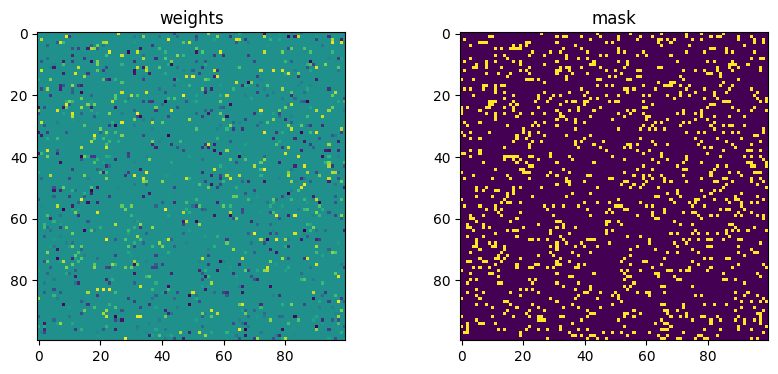

In [6]:
plt.figure(figsize=(10, 4))
plt.subplot(121).set_title('weights')
plt.imshow(brain.weights)
plt.subplot(122).set_title('mask')
plt.imshow(brain.mask)
plt.show()

### Brain predict history

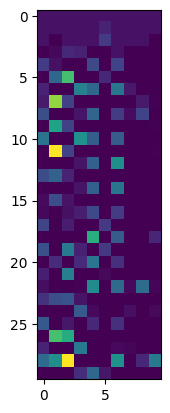

In [7]:
# History of output neuron fire
brain.initialize_neurons()
plt.imshow(brain.predict_history(np.array([1,]+[0]*9), 30, constant_input=False)); plt.show()

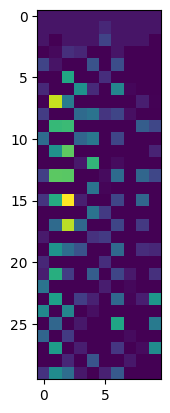

In [8]:
# History of output neuron fire with constant input
brain.initialize_neurons()
plt.imshow(brain.predict_history(np.array([1,]+[0]*9), 30, constant_input=True)); plt.show()

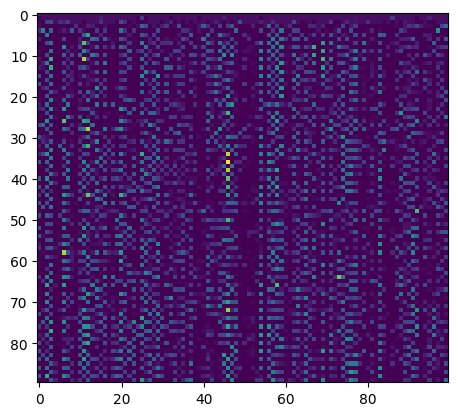

In [9]:
# History of all neurons
brain.initialize_neurons()
plt.imshow(brain.predict_brain_history(np.array([1,]+[0]*9), 90, constant_input=False)); plt.show()

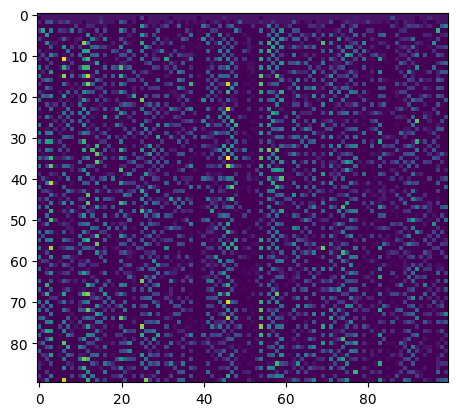

In [10]:
# History of all neurons with constant input
brain.initialize_neurons()
plt.imshow(brain.predict_brain_history(np.array([1,]+[0]*9), 90, constant_input=True)); plt.show()

### Brain response to different inputs

,0,1,2,3,4,5,6,7,8,9
0,3.935700,-1.000000,-1.000000,0.191845,5.625709,-1.000000,2.623747,-0.308754,3.118194,-1.000000
1,-1.000000,-1.000000,2.006653,-1.000000,7.917429,-1.000000,-1.000000,-1.000000,-1.000000,0.412379
2,0.632525,14.500953,6.588158,-1.000000,-1.000000,1.082403,6.963346,-0.256275,-1.000000,0.692933
3,2.078444,-1.000000,-1.000000,1.706902,1.035418,-0.553733,-1.000000,-1.000000,-1.000000,-1.000000
4,-1.000000,0.562623,-1.000000,4.031615,-1.000000,5.121793,-1.000000,-1.000000,-1.000000,-1.000000
5,-1.000000,-1.000000,-1.000000,-1.000000,4.373316,0.429114,-1.000000,-1.000000,-1.000000,-1.000000
6,-1.000000,-1.000000,-1.000000,1.453290,13.543540,1.952846,-1.000000,-1.000000,-1.000000,-1.000000
7,-1.000000,-1.000000,-1.000000,6.500956,10.031946,-1.000000,9.185116,-0.056334,-1.000000,-1.000000
8,0.577396,-1.000000,7.826581,2.022706,-1.000000,-1.000000,2.623747,-1.000000,4.106656,-1.000000
9,3.582964,-0.165284,-1.000000,3.978251,-1.000000,-1.000000,-0.500000,-1.000000,-1.000000,-1.000000


,0,1,2,3,4,5,6,7,8,9
0,-1.000000,-1.000000,-1.000000,-1.000000,11.892109,-1.000000,4.845517,-1.000000,-1.000000,1.169522
1,-0.786987,5.090349,5.083811,-1.000000,-1.000000,-1.000000,0.860608,-0.740018,4.868946,-0.954339
2,-1.000000,-1.000000,-1.000000,2.363464,-1.000000,-1.000000,2.873747,-0.262885,-1.000000,-1.000000
3,4.003958,-1.000000,-1.000000,-1.000000,-1.000000,-0.270985,-1.000000,-0.746955,-1.000000,-1.000000
4,0.833462,-1.000000,3.619152,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
5,-1.000000,-1.000000,-1.000000,4.663420,7.624045,-1.000000,2.623747,-1.000000,-1.000000,-1.000000
6,-1.000000,12.739342,11.911626,-1.000000,-1.000000,-1.000000,4.845517,-1.000000,-1.000000,7.483760
7,-1.000000,-1.000000,9.918818,-1.000000,2.889665,-1.000000,-1.000000,2.302143,-0.311238,-1.000000
8,1.771033,6.991542,0.715206,-1.000000,-1.000000,0.880032,-1.000000,-1.000000,3.955470,-1.000000
9,-1.000000,-1.000000,2.916369,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


,0,1,2,3,4,5,6,7,8,9
0,-1.000000,8.371576,-1.000000,4.202605,-0.000403,-1.000000,4.845517,-1.000000,2.520715,3.068185
1,-1.000000,8.586280,8.788831,-1.000000,-1.000000,-1.000000,4.845517,-1.000000,3.151656,-0.412455
2,-0.998865,-1.000000,-1.000000,3.637492,-1.000000,-1.000000,2.623747,1.433222,-1.000000,-1.000000
3,-1.000000,-1.000000,-1.000000,4.229607,2.114115,1.211048,-1.000000,-0.910878,-1.000000,-1.000000
4,-1.000000,-1.000000,8.005880,-1.000000,1.190555,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
5,0.980623,-1.000000,7.176350,3.389391,-1.000000,-1.000000,3.839598,1.616861,-1.000000,-1.000000
6,-1.000000,2.147129,4.566260,-1.000000,-1.000000,5.768284,1.762585,-1.000000,-1.000000,-1.000000
7,-1.000000,5.808799,-1.000000,-0.493324,7.312177,-1.000000,6.963346,-1.000000,-1.000000,3.150204
8,-1.000000,6.121003,10.175071,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4.758936,2.695865
9,2.708582,8.091621,4.338938,-1.000000,8.670223,4.037545,-1.000000,0.266244,-1.000000,-1.000000


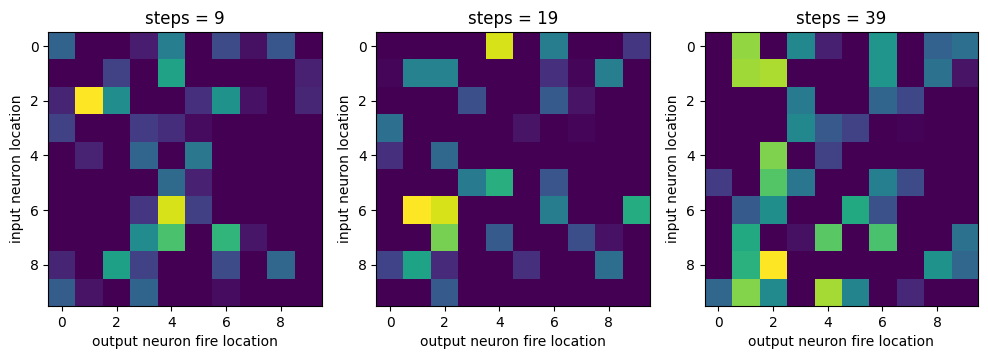

In [11]:
# non-constant inputs vs outputs at various timesteps
plt.figure(figsize=(12, 6))
steps = [9, 19, 39]
plt_subplot = 101 + 10 * len(steps)
for step in steps:
    pred = np.zeros((10, brain.n_outputs), dtype='float32')
    for i in range(10):
        brain.initialize_neurons()
        pred[i] = brain.predict(np.array([0]*i+[1]+[0]*(9 - i)), step, constant_input=False)
    display(pd.DataFrame(pred))
    plt.subplot(plt_subplot).set_title(f'steps = {step}')
    plt.imshow(pred)
    plt.ylabel('input neuron location'); plt.xlabel('output neuron fire location'); 
    plt_subplot += 1
plt.show()

,0,1,2,3,4,5,6,7,8,9
0,2.058020,-1.000000,-1.000000,5.004179,5.625709,1.691742,2.623747,-0.308754,-1.000000,-1.000000
1,-1.000000,-1.000000,2.006653,-1.000000,7.917429,-1.000000,-1.000000,-1.000000,-1.000000,0.412379
2,0.632525,14.500953,6.588158,-1.000000,-1.000000,1.082403,6.963346,-0.256275,-1.000000,0.692933
3,5.101779,-1.000000,-1.000000,1.706902,1.911442,-0.553733,-1.000000,-1.000000,-1.000000,-1.000000
4,4.733255,-1.000000,-1.000000,3.055309,-1.000000,-1.000000,2.623747,-1.000000,-1.000000,-1.000000
5,-1.000000,-1.000000,-1.000000,0.883509,-0.500000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
6,-1.000000,-1.000000,-1.000000,-1.000000,13.543540,1.952846,-1.000000,-1.000000,-1.000000,0.945199
7,-1.000000,-1.000000,-1.000000,11.196885,2.114115,-1.000000,-0.500000,-0.641976,1.843674,-1.000000
8,2.523335,-1.000000,7.714900,-1.000000,-1.000000,-1.000000,2.623747,-1.000000,2.925541,-1.000000
9,3.582964,-0.165284,-1.000000,3.978251,-1.000000,-1.000000,-0.500000,-1.000000,-1.000000,-1.000000


,0,1,2,3,4,5,6,7,8,9
0,0.269984,-1.000000,-1.000000,-1.000000,1.447384,1.952846,-1.000000,-1.000000,-1.000000,-1.000000
1,-0.087843,2.431581,-1.000000,7.461655,-1.000000,-1.000000,9.185116,-1.000000,3.172812,3.421356
2,5.162124,9.531854,5.138148,-1.000000,-1.000000,-0.500000,-1.000000,-1.000000,-1.000000,5.795442
3,3.707237,-1.000000,0.237811,-1.000000,10.531544,-1.000000,-0.954954,-1.000000,-1.000000,-1.000000
4,6.348965,-1.000000,-1.000000,1.366143,10.499024,-1.000000,-1.000000,1.539956,-1.000000,-1.000000
5,2.713793,-1.000000,-1.000000,-1.000000,4.491899,6.420125,-1.000000,3.149476,-1.000000,-0.506804
6,2.038561,-1.000000,6.867652,-1.000000,-1.000000,-1.000000,-1.000000,-0.324393,1.882944,0.964085
7,-1.000000,-1.000000,-1.000000,-1.000000,9.365215,5.082246,-1.000000,-1.000000,-1.000000,-1.000000
8,4.625964,3.028768,-1.000000,-1.000000,-1.000000,3.065786,-1.000000,-1.000000,-1.000000,4.368636
9,-1.000000,2.961785,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


,0,1,2,3,4,5,6,7,8,9
0,1.709921,8.352116,-1.000000,-1.000000,1.045776,-1.000000,-1.000000,-1.0,-1.000000,-1.000000
1,3.030938,6.307784,3.825541,-1.000000,0.151608,1.095900,4.845517,-1.0,-1.000000,3.833556
2,2.132896,7.418875,12.487556,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,0.078361,2.695865
3,0.980623,-1.000000,7.075139,3.048633,-1.000000,-1.000000,-0.500000,-1.0,-1.000000,-1.000000
4,-1.000000,4.374673,11.964267,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000
5,3.157620,4.375212,-1.000000,-1.000000,-1.000000,-0.850707,-1.000000,-1.0,-1.000000,-1.000000
6,3.132234,6.473301,4.709015,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,1.223505,2.695865
7,-1.000000,12.318329,8.942683,-0.455831,-1.000000,-1.000000,1.721770,-1.0,3.151656,1.388610
8,-1.000000,-1.000000,-1.000000,7.867642,-1.000000,-1.000000,2.623747,-1.0,-1.000000,-1.000000
9,0.577396,9.319843,-1.000000,3.861847,4.579530,-1.000000,2.623747,-1.0,-1.000000,-1.000000


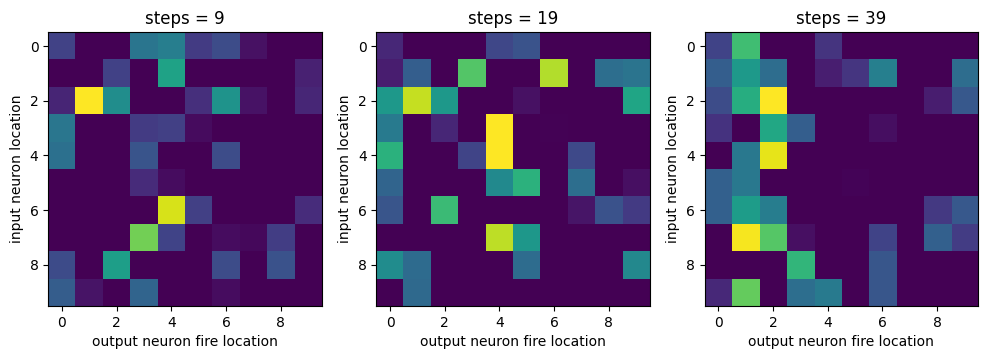

In [12]:
# constant inputs vs outputs at various timesteps
plt.figure(figsize=(12, 6))
steps = [9, 19, 39]
plt_subplot = 101 + 10 * len(steps)
for step in steps:
    pred = np.zeros((10, brain.n_outputs), dtype='float32')
    for i in range(10):
        brain.initialize_neurons()
        pred[i] = brain.predict(np.array([0]*i+[1]+[0]*(9 - i)), step, constant_input=True)
    display(pd.DataFrame(pred))
    plt.subplot(plt_subplot).set_title(f'steps = {step}')
    plt.imshow(pred)
    plt.ylabel('input neuron location'); plt.xlabel('output neuron fire location'); 
    plt_subplot += 1
plt.show()

### constant inputs vs outputs at various timesteps

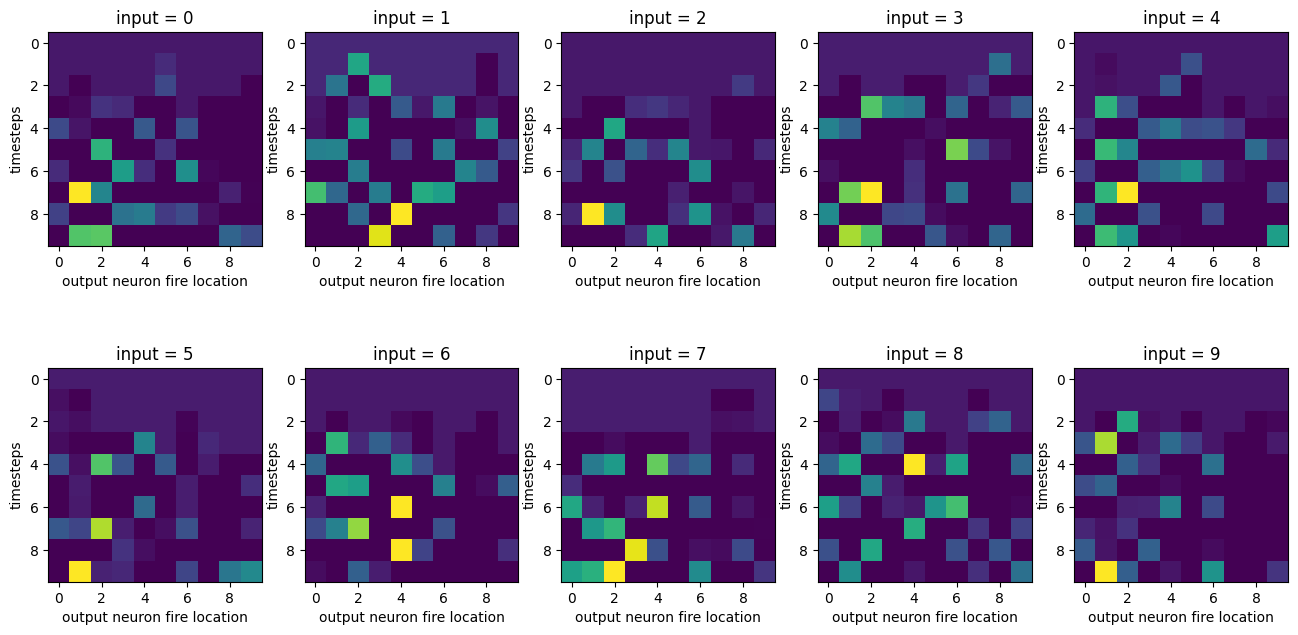

In [13]:
# constant inputs vs outputs at various timesteps
plt.figure(figsize=(16, 8))
plt_subplot = [2, 5, 1]
for i in range(10):
    brain.initialize_neurons()
    pred = brain.predict_history(np.array([0]*i+[1]+[0]*(9 - i)), steps=10, constant_input=True)
    #print(pred)
    plt.subplot(*plt_subplot).set_title(f'input = {i}')
    plt.imshow(pred)
    plt.ylabel('timesteps'); plt.xlabel('output neuron fire location'); 
    plt_subplot[2] += 1
plt.show()

### non-constant inputs vs outputs at various timesteps

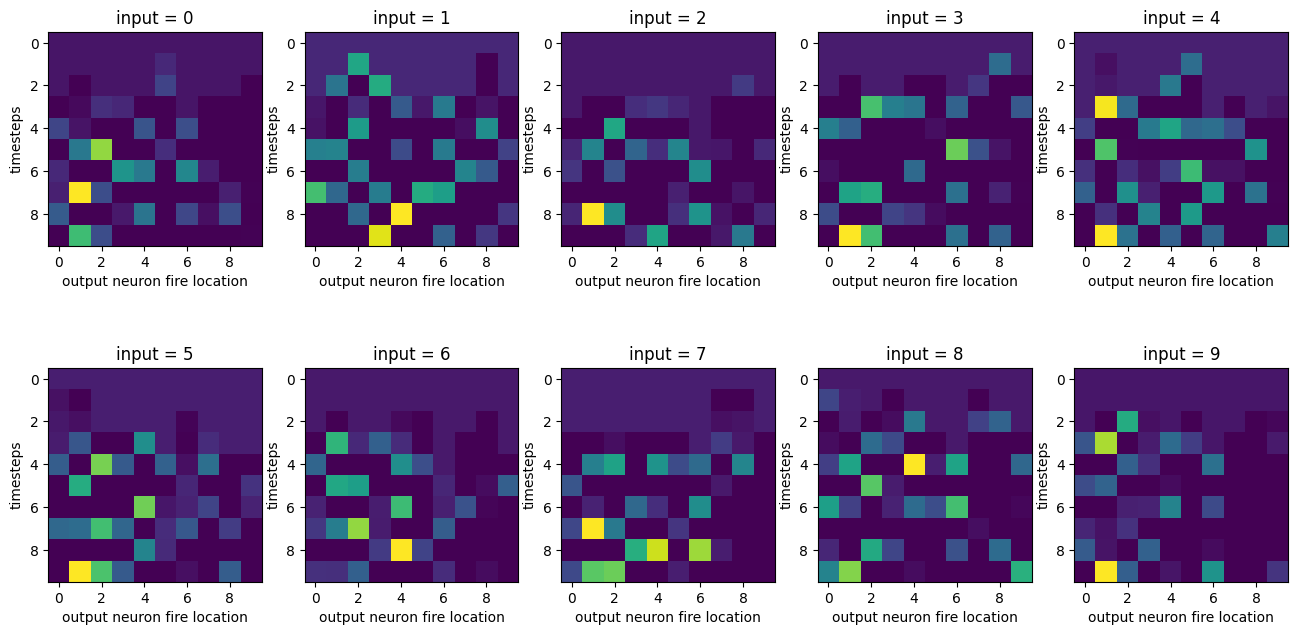

In [14]:
# non-constant inputs vs outputs at various timesteps
plt.figure(figsize=(16, 8))
plt_subplot = [2, 5, 1]
for i in range(10):
    brain.initialize_neurons()
    pred = brain.predict_history(np.array([0]*i+[1]+[0]*(9 - i)), steps=10, constant_input=False)
    #print(pred)
    plt.subplot(*plt_subplot).set_title(f'input = {i}')
    plt.imshow(pred)
    plt.ylabel('timesteps'); plt.xlabel('output neuron fire location'); 
    plt_subplot[2] += 1
plt.show()

### Train with Hebbian like theory

Non-constant input


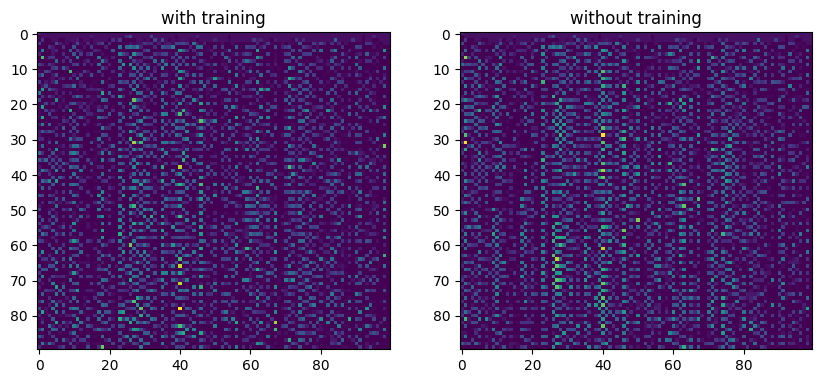

In [15]:
print('Non-constant input')
plt.figure(figsize=(10, 5))
# with training
brain.initialize_neurons()
brain.initialize_weights(2030)
plt.subplot(1, 2, 1).set_title('with training')
plt.imshow(brain.train_hebbian_brain_history(np.array([1,]+[0]*9), 90, lr=0.05, constant_input=False))

# without training
brain.initialize_neurons()
brain.initialize_weights(2030)
plt.subplot(1, 2, 2).set_title('without training')
plt.imshow(brain.predict_brain_history(np.array([1,]+[0]*9), 90, constant_input=False))
plt.show()

Constant input


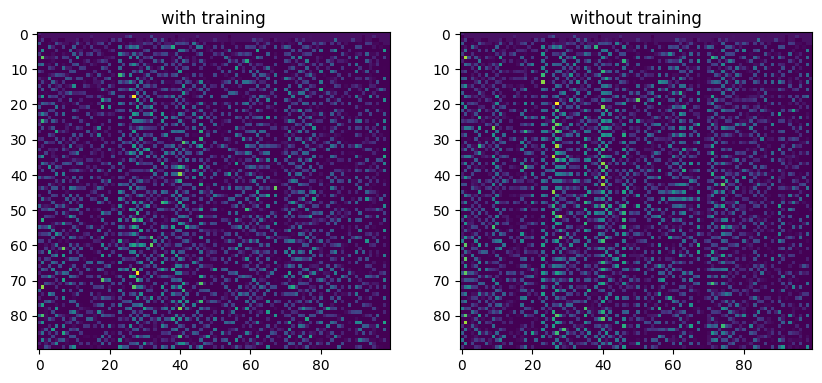

In [16]:
print('Constant input')
plt.figure(figsize=(10, 5))
# with training
brain.initialize_neurons()
brain.initialize_weights(2030)
plt.subplot(1, 2, 1).set_title('with training')
plt.imshow(brain.train_hebbian_brain_history(np.array([1,]+[0]*9), 90, lr=0.05, constant_input=True))

# without training
brain.initialize_neurons()
brain.initialize_weights(2030)
plt.subplot(1, 2, 2).set_title('without training')
plt.imshow(brain.predict_brain_history(np.array([1,]+[0]*9), 90, constant_input=True))
plt.show()

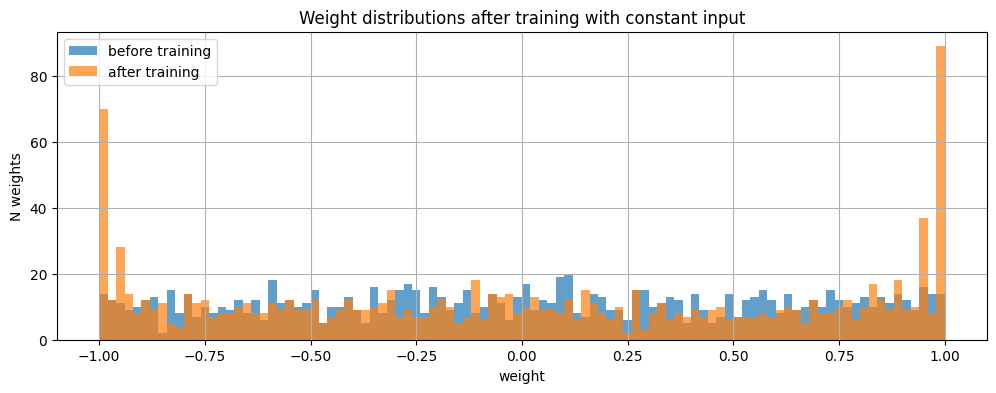

In [17]:
# Weights
plt_bins = np.arange(-1, 1.02, 0.02)
plt.figure(figsize=(12, 4))
plt.title('Weight distributions after training with constant input')
brain.initialize_neurons()
brain.initialize_weights(2030)
plt.hist(brain.weights.reshape(-1)[brain.mask.reshape(-1)], bins=plt_bins, label='before training', alpha=0.7)
brain.train_hebbian_brain_history(np.array([1,]+[0]*9), 90, lr=0.05, constant_input=True)
plt.hist(brain.weights.reshape(-1)[brain.mask.reshape(-1)], bins=plt_bins, label='after training', alpha=0.7)
plt.xlabel('weight'); plt.ylabel('N weights')
plt.legend(); plt.grid(); plt.show()

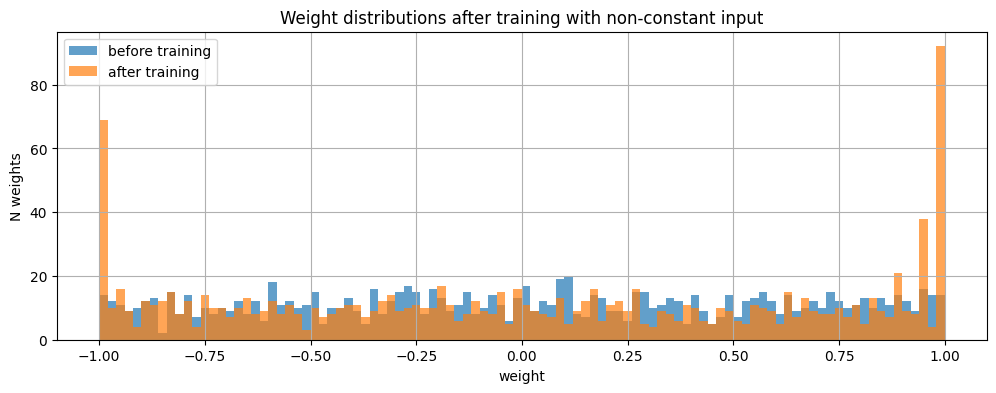

In [18]:
# Weights
plt_bins = np.arange(-1, 1.02, 0.02)
plt.figure(figsize=(12, 4))
plt.title('Weight distributions after training with non-constant input')
brain.initialize_neurons()
brain.initialize_weights(2030)
plt.hist(brain.weights.reshape(-1)[brain.mask.reshape(-1)], bins=plt_bins, label='before training', alpha=0.7)
brain.train_hebbian_brain_history(np.array([1,]+[0]*9), 90, lr=0.05, constant_input=False)
plt.hist(brain.weights.reshape(-1)[brain.mask.reshape(-1)], bins=plt_bins, label='after training', alpha=0.7)
plt.xlabel('weight'); plt.ylabel('N weights')
plt.legend(); plt.grid(); plt.show()

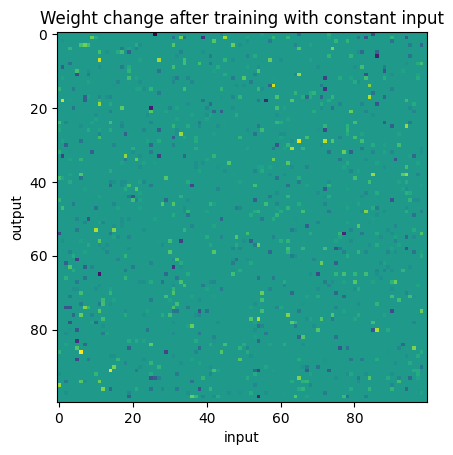

In [19]:
# Weights change
# plt.figure(figsize=(12, 4))
plt.title('Weight change after training with constant input')
brain.initialize_neurons()
brain.initialize_weights(2030)
W_before = brain.weights
brain.train_hebbian_brain_history(np.array([1,]+[0]*9), 90, lr=0.05, constant_input=True)
dW = brain.weights - W_before
plt.imshow(dW)
plt.xlabel('input'); plt.ylabel('output')
plt.show()

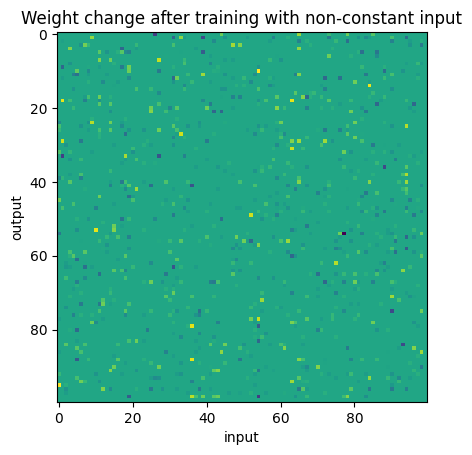

In [20]:
# Weights change
# plt.figure(figsize=(12, 4))
plt.title('Weight change after training with non-constant input')
brain.initialize_neurons()
brain.initialize_weights(2030)
W_before = brain.weights
brain.train_hebbian_brain_history(np.array([1,]+[0]*9), 90, lr=0.05, constant_input=False)
dW = brain.weights - W_before
plt.imshow(dW)
plt.xlabel('input'); plt.ylabel('output')
plt.show()

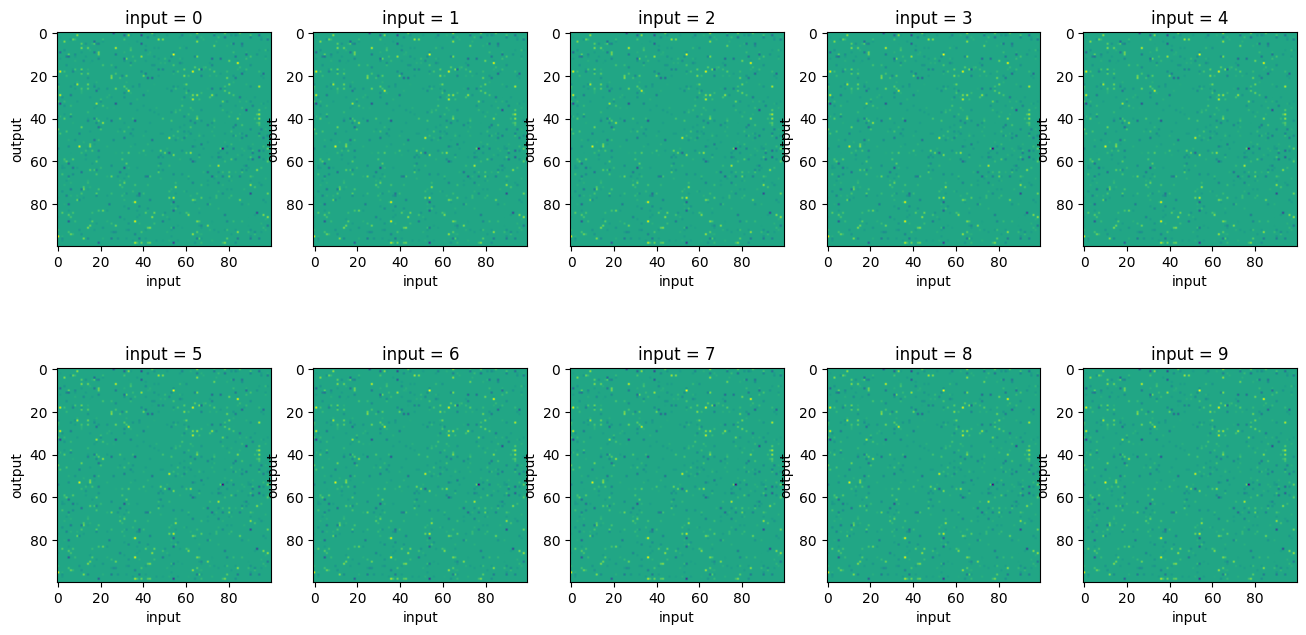

In [21]:
# weight change for various constant inputs
plt.figure(figsize=(16, 8))
plt_subplot = [2, 5, 1]
for i in range(10):
    brain.initialize_neurons()
    brain.initialize_weights(2030)
    W_before = brain.weights
    brain.train_hebbian_brain_history(np.array([1,]+[0]*9), 90, lr=0.05, constant_input=False)
    dW = brain.weights - W_before
    plt.subplot(*plt_subplot).set_title(f'input = {i}')
    plt.imshow(dW)
    plt.ylabel('output'); plt.xlabel('input'); 
    plt_subplot[2] += 1
plt.show()

### On real image

In [22]:
df_train = pd.read_csv('/Users/jeongseohyeon/Downloads/digit-recognizer/train.csv')
df_test = pd.read_csv('/Users/jeongseohyeon/Downloads/digit-recognizer/test.csv')

cols_pixels = [c for c in df_train.columns if c != 'label']

y_train = df_train['label']
x_train = df_train[cols_pixels].values
x_test = df_test[cols_pixels].values

x_train = x_train / 255
x_test = x_test / 255

print(x_train.shape, x_test.shape, y_train.shape)
print(x_train.min(), x_train.max())

(42000, 784) (28000, 784) (42000,)
0.0 1.0


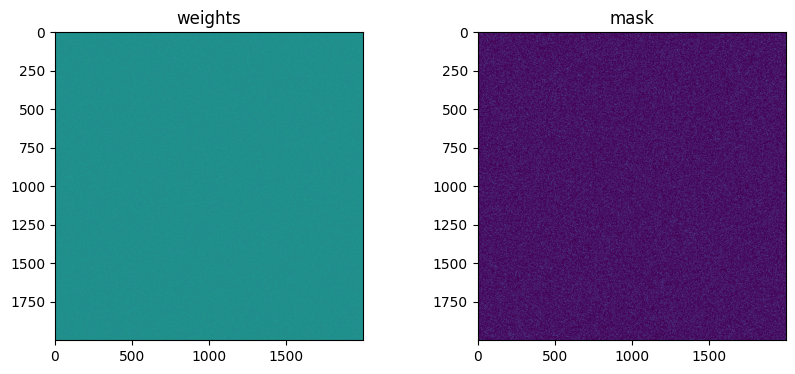

In [23]:
# Create our brain
brain_mnist = Brain(n_neurons=2000, n_inputs=784, n_outputs=10, n_connections=100)

plt.figure(figsize=(10, 4))
plt.subplot(121).set_title('weights')
plt.imshow(brain_mnist.weights)
plt.subplot(122).set_title('mask')
plt.imshow(brain_mnist.mask)
plt.show()

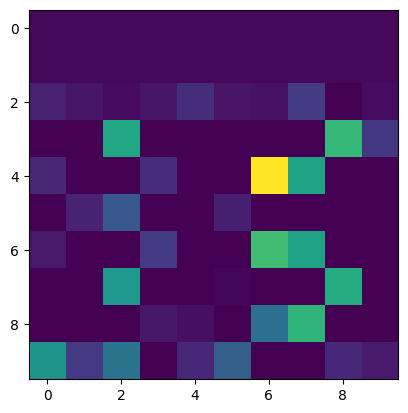

In [24]:
plt.imshow(brain_mnist.predict_history(x_train[0], constant_input=True)); plt.show()

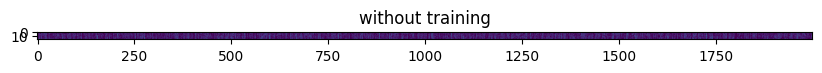

In [25]:
# before training
plt.figure(figsize=(10, 5))
brain_mnist.initialize_neurons()
brain_mnist.initialize_weights(2030)
plt.title('without training')
plt.imshow(brain_mnist.predict_brain_history(x_train[0], 20, constant_input=True))
plt.show()

weights_before = brain_mnist.weights.reshape(-1)[brain_mnist.mask.reshape(-1)]

In [26]:
%%time
# training
brain_mnist.train_hebbian_brain_batch(x_train, 1000)

training steps: 100 x 10


  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 2min 10s, sys: 2min 31s, total: 4min 42s
Wall time: 26.5 s


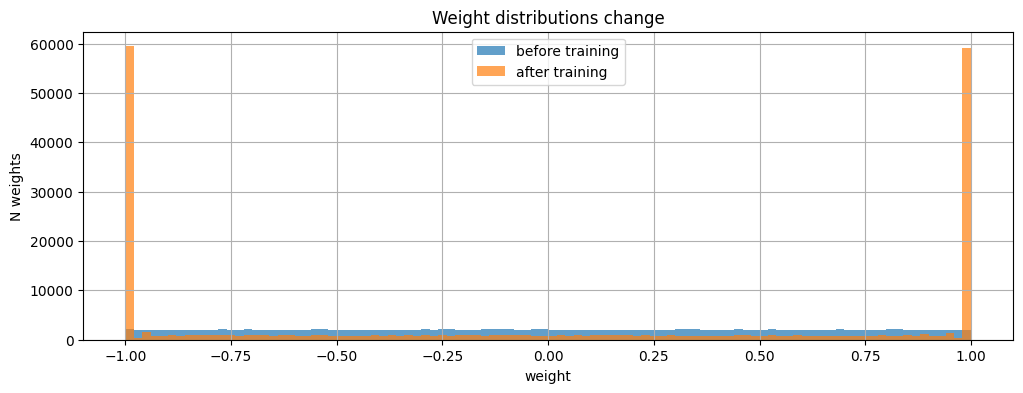

In [27]:
# Weights
plt_bins = np.arange(-1, 1.02, 0.02)
plt.figure(figsize=(12, 4))
plt.title('Weight distributions change')
plt.hist(weights_before, bins=plt_bins, label='before training', alpha=0.7)
plt.hist(brain_mnist.weights.reshape(-1)[brain_mnist.mask.reshape(-1)], bins=plt_bins, label='after training', alpha=0.7)
plt.xlabel('weight'); plt.ylabel('N weights')
plt.legend(); plt.grid(); plt.show()

plt.imshow(brain_mnist.predict_history(x_train[0], constant_input=True)); plt.show()

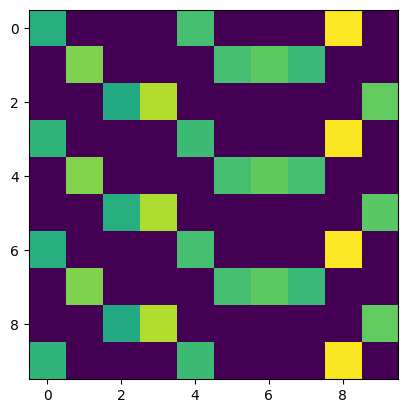

In [28]:
plt.imshow(brain_mnist.predict_history(x_train[333], constant_input=True)); plt.show()

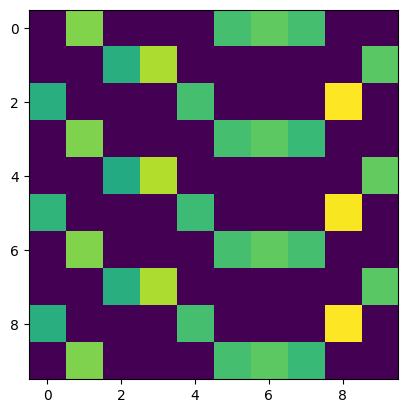

In [29]:
plt.imshow(brain_mnist.predict_history(x_train[333], constant_input=False)); plt.show()

## SNN with BindsNet

In [30]:
!pip install git+https://github.com/BindsNET/bindsnet.git

476.66s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


  Cloning https://github.com/BindsNET/bindsnet.git to /private/var/folders/fw/v4x3fkk94qvbl08b9n5jw7w40000gn/T/pip-req-build-uvi0he13
  Running command git clone --filter=blob:none --quiet https://github.com/BindsNET/bindsnet.git /private/var/folders/fw/v4x3fkk94qvbl08b9n5jw7w40000gn/T/pip-req-build-uvi0he13
  Resolved https://github.com/BindsNET/bindsnet.git to commit 27441de8da8801a46ebd1ee6c573b6c1e261ccc1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 988.3/988.3 kB 6.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 11.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 11.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 14.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 13.8 MB/s eta 0:00:0000:0100:01
  

In [31]:
import os
import matplotlib.pyplot as plt
import numpy as np
import gc

import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision
from tqdm.notebook import tqdm

from bindsnet.analysis.plotting import (
    plot_assignments,
    plot_input,
    plot_performance,
    plot_spikes,
    plot_voltages,
    plot_weights,
)
from bindsnet.datasets import MNIST
from bindsnet.encoding import PoissonEncoder
from bindsnet.evaluation import all_activity, assign_labels, proportion_weighting
from bindsnet.models import DiehlAndCook2015
from bindsnet.network.monitors import Monitor
from bindsnet.utils import get_square_assignments, get_square_weights

from sklearn.model_selection import train_test_split

In [32]:
train = pd.read_csv(r"/Users/jeongseohyeon/Downloads/digit-recognizer/train.csv", dtype=np.float32)
test = pd.read_csv(r"/Users/jeongseohyeon/Downloads/digit-recognizer/test.csv", dtype=np.float32)
submission = pd.read_csv("../input/digit-recognizer/sample_submission.csv")

data_train = (train.loc[:, train.columns != "label"].values/255.).reshape(-1, 28, 28)
label_train = train.label.values
X_test = (test.values/255.).reshape(-1, 28, 28)

X_train, X_valid, y_train, y_valid = train_test_split(
                                                      data_train,
                                                      label_train,
                                                      test_size=0.2,
                                                      shuffle=True,
                                                      random_state=2021
                                                     ) 
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)

X_valid = torch.from_numpy(X_valid)
y_valid = torch.from_numpy(y_valid).type(torch.LongTensor)

X_test = torch.from_numpy(X_test)

del train, data_train, label_train

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/my_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/fw/v4x3fkk94qvbl08b9n5jw7w40000gn/T/ipykernel_62823/3312679738.py", line 3, in <module>
    submission = pd.read_csv("../input/digit-recognizer/sample_submission.csv")
  File "/opt/homebrew/anaconda3/envs/my_env/lib/python3.10/site-packages/pandas/util/_decorators.py", line 211, in wrapper
    raise TypeError(msg)
  File "/opt/homebrew/anaconda3/envs/my_env/lib/python3.10/site-packages/pandas/util/_decorators.py", line 331, in wrapper
    stacklevel=find_stack_level(),
  File "/opt/homebrew/anaconda3/envs/my_env/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 950, in read_csv
  File "/opt/homebrew/anaconda3/envs/my_env/lib/python3.10/site-packages/pandas/io/parsers/readers.py", line 605, in _read
    nrows = kwds.get("nrows", None)


In [33]:
n_train = len(y_train)
n_test = 100
time = 250
dt = 1.0
intensity = 32

transform=transforms.Compose([transforms.Lambda(lambda x: x * intensity)])

train_dataset = []
for i in range(n_train):
    train_dataset.append({"image":X_train[i], "encoded_image": PoissonEncoder(time=time, dt=dt)(transform((X_train[i]).reshape(-1, 28, 28))), "label": y_train[i]})

valid_dataset = []
for i in range(n_test):
    valid_dataset.append({"image":X_valid[i], "encoded_image": PoissonEncoder(time=time, dt=dt)(transform((X_valid[i]).reshape(-1, 28, 28))), "label": y_valid[i]})

test_dataset = []
for i in range(len(X_test)):
    test_dataset.append({"image":X_test[i], "encoded_image": PoissonEncoder(time=time, dt=dt)(transform((X_test[i]).reshape(-1, 28, 28)))})

NameError: name 'X_train' is not defined

MNIST

In [34]:
#!pip install brian2

817.71s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 8.8 MB/s eta 0:00:00a 0:00:01


In [37]:
from keras.datasets import mnist
from brian2 import *
import brian2.numpy_ as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [38]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# simplified classification (0 1 and 8)
X_train = X_train[(y_train == 1) | (y_train == 0) | (y_train == 8)]
y_train = y_train[(y_train == 1) | (y_train == 0) | (y_train == 8)]
X_test = X_test[(y_test == 1) | (y_test == 0) | (y_test == 8)]
y_test = y_test[(y_test == 1) | (y_test == 0) | (y_test == 8)]

# pixel intensity to Hz (255 becoms ~63Hz)
X_train = X_train / 4 
X_test = X_test / 4

X_train.shape, X_test.shape

11490434/11490434 [==============================] - 2s 0us/step


((18516, 28, 28), (3089, 28, 28))

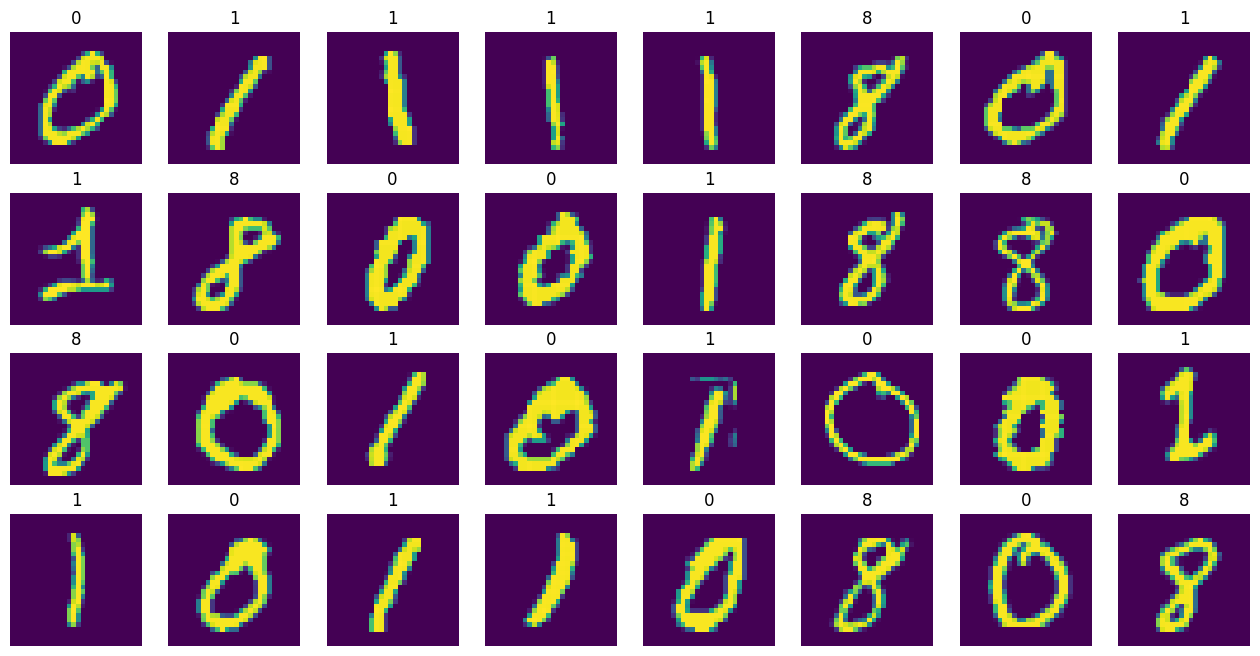

In [39]:
plt.figure(figsize=(16,8))
for img in range(32):
    plt.subplot(4,8,1+img)
    plt.title(y_train[img])
    plt.imshow(X_train[img])
    plt.axis('off')

In [40]:
n_input = 28*28 # input layer
n_e = 100 # e - excitatory
n_i = n_e # i - inhibitory

v_rest_e = -60.*mV # v - membrane potential
v_reset_e = -65.*mV
v_thresh_e = -52.*mV

v_rest_i = -60.*mV
v_reset_i = -45.*mV
v_thresh_i = -40.*mV

taupre = 20*ms
taupost = taupre
gmax = .05 #.01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax 
dApre *= gmax 

# Apre and Apost - presynaptic and postsynaptic traces, lr - learning rate
stdp='''w : 1
    lr : 1 (shared)
    dApre/dt = -Apre / taupre : 1 (event-driven)
    dApost/dt = -Apost / taupost : 1 (event-driven)'''
pre='''ge += w
    Apre += dApre
    w = clip(w + lr*Apost, 0, gmax)'''
post='''Apost += dApost
    w = clip(w + lr*Apre, 0, gmax)'''

class Model():
    
    def __init__(self, debug=False):
        app = {}
                
        # input images as rate encoded Poisson generators
        app['PG'] = PoissonGroup(n_input, rates=np.zeros(n_input)*Hz, name='PG')
        
        # excitatory group
        neuron_e = '''
            dv/dt = (ge*(0*mV-v) + gi*(-100*mV-v) + (v_rest_e-v)) / (100*ms) : volt
            dge/dt = -ge / (5*ms) : 1
            dgi/dt = -gi / (10*ms) : 1
            '''
        app['EG'] = NeuronGroup(n_e, neuron_e, threshold='v>v_thresh_e', refractory=5*ms, reset='v=v_reset_e', method='euler', name='EG')
        app['EG'].v = v_rest_e - 20.*mV
        
        if (debug):
            app['ESP'] = SpikeMonitor(app['EG'], name='ESP')
            app['ESM'] = StateMonitor(app['EG'], ['v'], record=True, name='ESM')
            app['ERM'] = PopulationRateMonitor(app['EG'], name='ERM')
        
        # ibhibitory group
        neuron_i = '''
            dv/dt = (ge*(0*mV-v) + (v_rest_i-v)) / (10*ms) : volt
            dge/dt = -ge / (5*ms) : 1
            '''
        app['IG'] = NeuronGroup(n_i, neuron_i, threshold='v>v_thresh_i', refractory=2*ms, reset='v=v_reset_i', method='euler', name='IG')
        app['IG'].v = v_rest_i - 20.*mV

        if (debug):
            app['ISP'] = SpikeMonitor(app['IG'], name='ISP')
            app['ISM'] = StateMonitor(app['IG'], ['v'], record=True, name='ISM')
            app['IRM'] = PopulationRateMonitor(app['IG'], name='IRM')
        
        # poisson generators one-to-all excitatory neurons with plastic connections 
        app['S1'] = Synapses(app['PG'], app['EG'], stdp, on_pre=pre, on_post=post, method='euler', name='S1')
        app['S1'].connect()
        app['S1'].w = 'rand()*gmax' # random weights initialisation
        app['S1'].lr = 1 # enable stdp        
        
        if (debug):
            # some synapses
            app['S1M'] = StateMonitor(app['S1'], ['w', 'Apre', 'Apost'], record=app['S1'][380,:4], name='S1M') 
        
        # excitatory neurons one-to-one inhibitory neurons
        app['S2'] = Synapses(app['EG'], app['IG'], 'w : 1', on_pre='ge += w', name='S2')
        app['S2'].connect(j='i')
        app['S2'].delay = 'rand()*10*ms'
        app['S2'].w = 3 # very strong fixed weights to ensure corresponding inhibitory neuron will always fire

        # inhibitory neurons one-to-all-except-one excitatory neurons
        app['S3'] = Synapses(app['IG'], app['EG'], 'w : 1', on_pre='gi += w', name='S3')
        app['S3'].connect(condition='i!=j')
        app['S3'].delay = 'rand()*5*ms'
        app['S3'].w = .03 # weights are selected in such a way as to maintain a balance between excitation and ibhibition
        
        self.net = Network(app.values())
        self.net.run(0*second)
        
    def __getitem__(self, key):
        return self.net[key]
    
    def train(self, X, epoch=1):        
        self.net['S1'].lr = 1 # stdp on
        
        for ep in range(epoch):
            for idx in range(len(X)):
                # active mode
                self.net['PG'].rates = X[idx].ravel()*Hz
                self.net.run(0.35*second)

                # passive mode
                self.net['PG'].rates = np.zeros(n_input)*Hz
                self.net.run(0.15*second)
        
    def evaluate(self, X):       
        self.net['S1'].lr = 0  # stdp off
        
        features = []
        for idx in range(len(X)):
            # rate monitor to count spikes
            mon = SpikeMonitor(self.net['EG'], name='RM')
            self.net.add(mon)
            
            # active mode
            self.net['PG'].rates = X[idx].ravel()*Hz
            self.net.run(0.35*second)
            
            # spikes per neuron foreach image
            features.append(np.array(mon.count, dtype=int8))
            
            # passive mode
            self.net['PG'].rates = np.zeros(n_input)*Hz
            self.net.run(0.15*second)
            
            self.net.remove(self.net['RM'])
            
        return features

WARNING    'i' is an internal variable of group 'S2', but also exists in the run namespace with the value 0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'i' is an internal variable of group 'S3', but also exists in the run namespace with the value 0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'dt' is an internal variable of group 'PG', but also exists in the run namespace with the value 1.0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


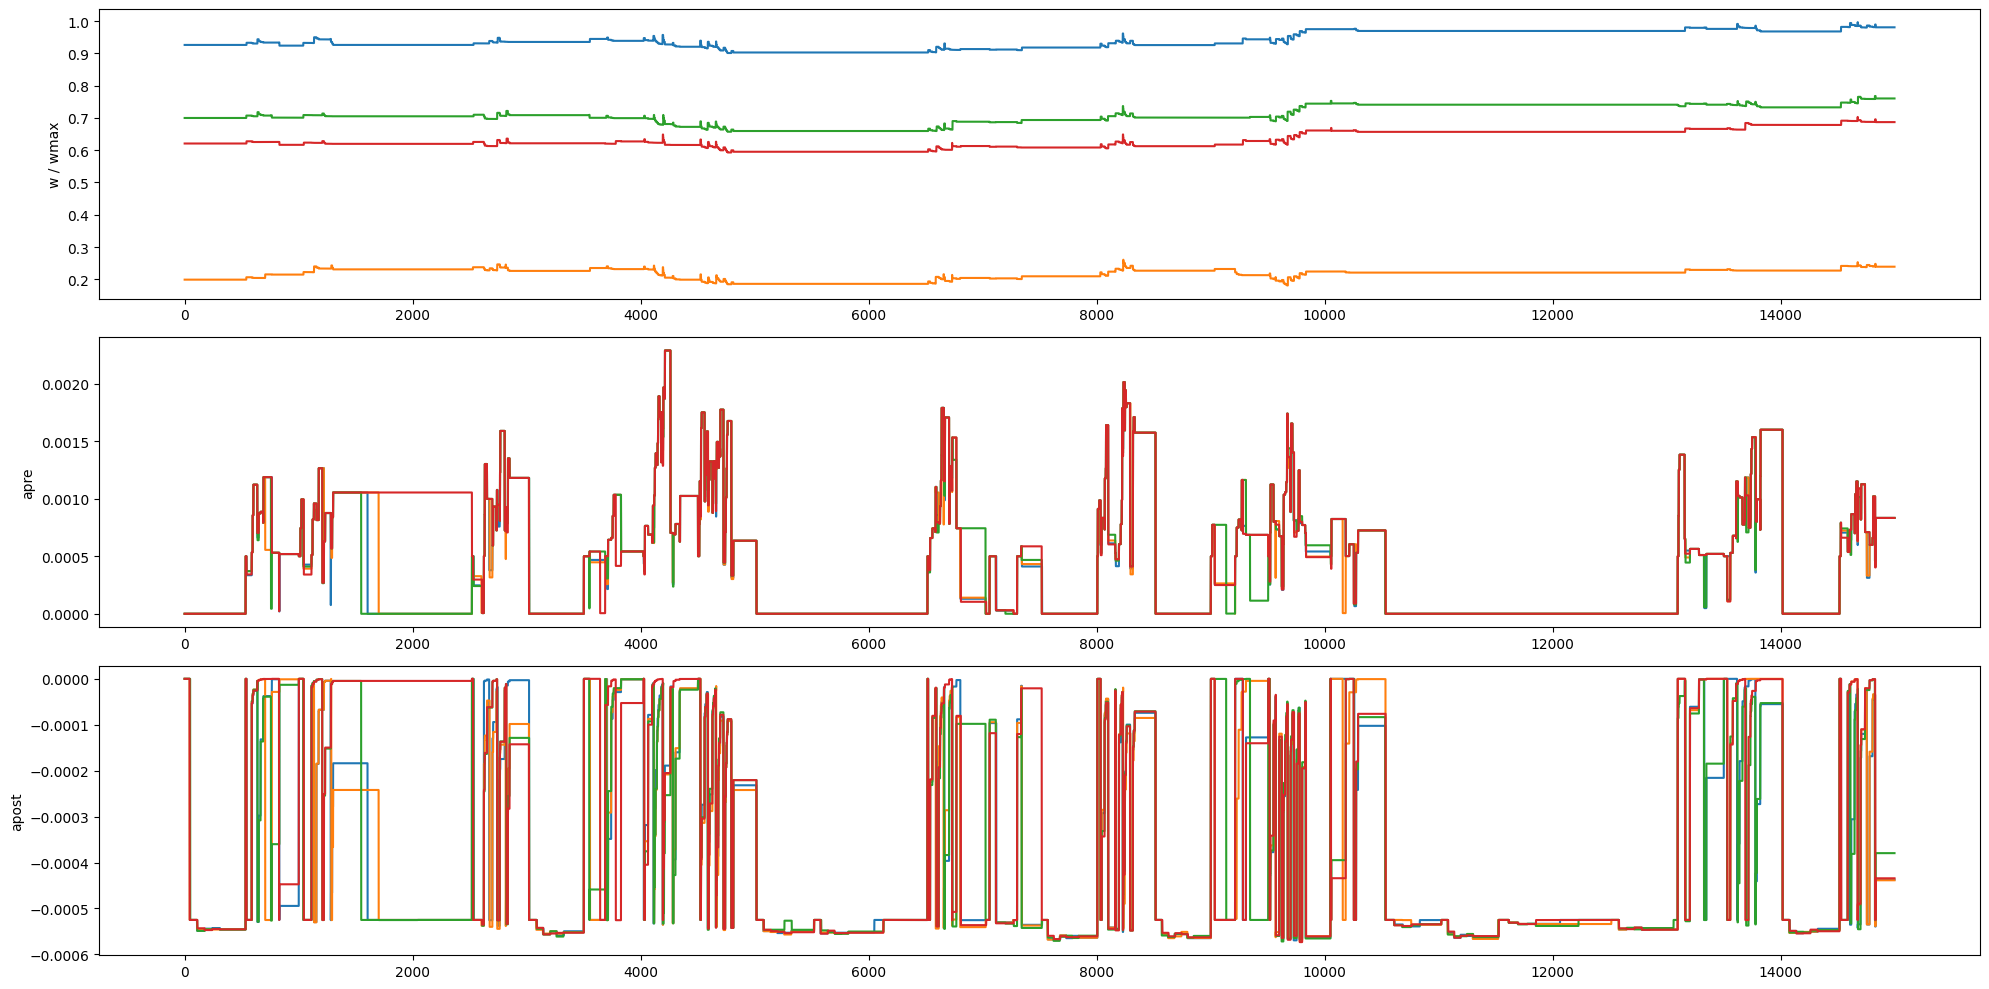

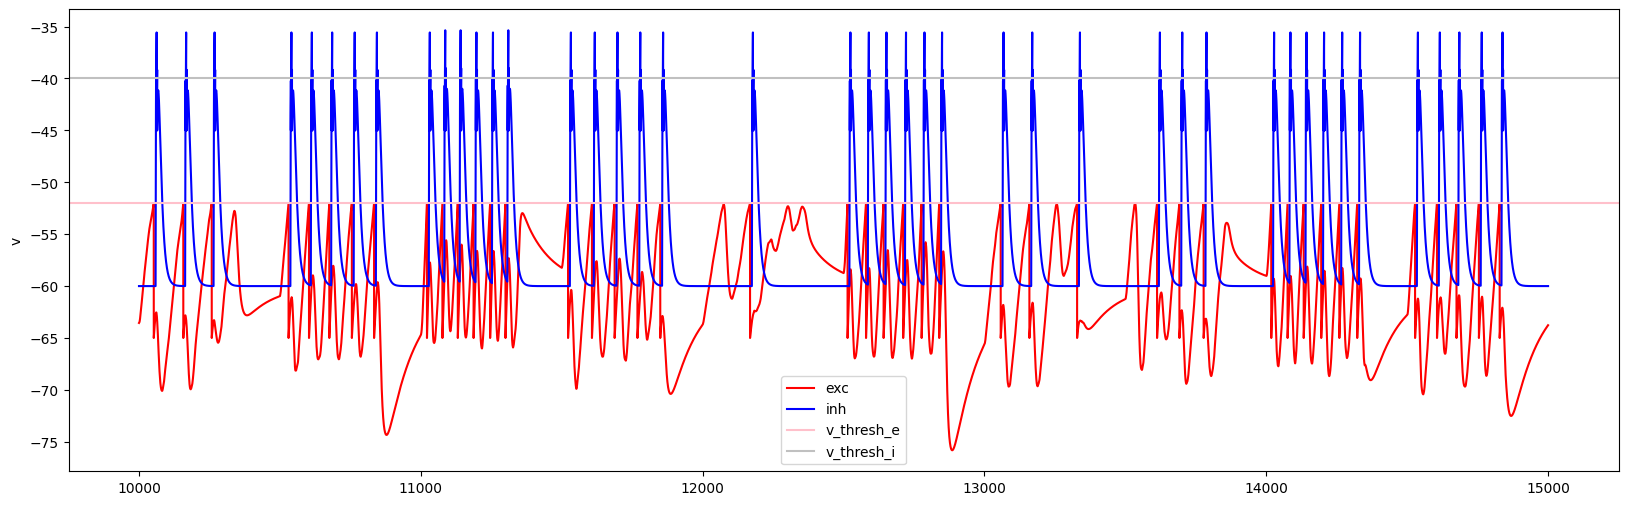

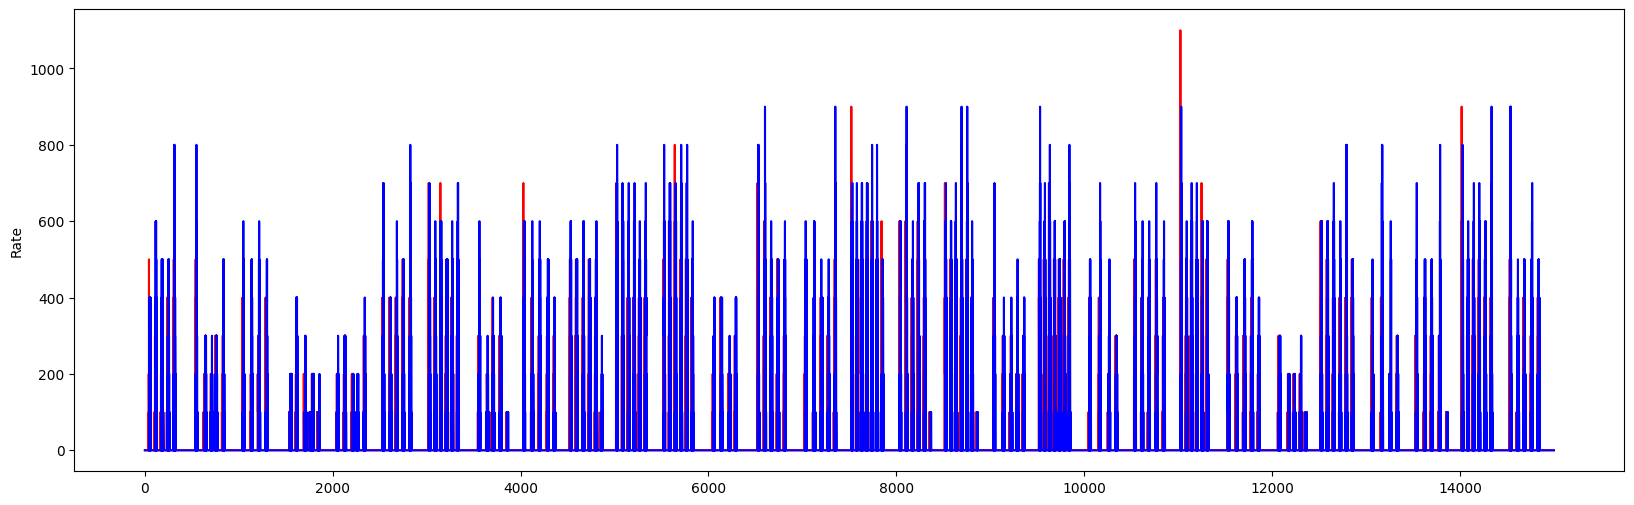

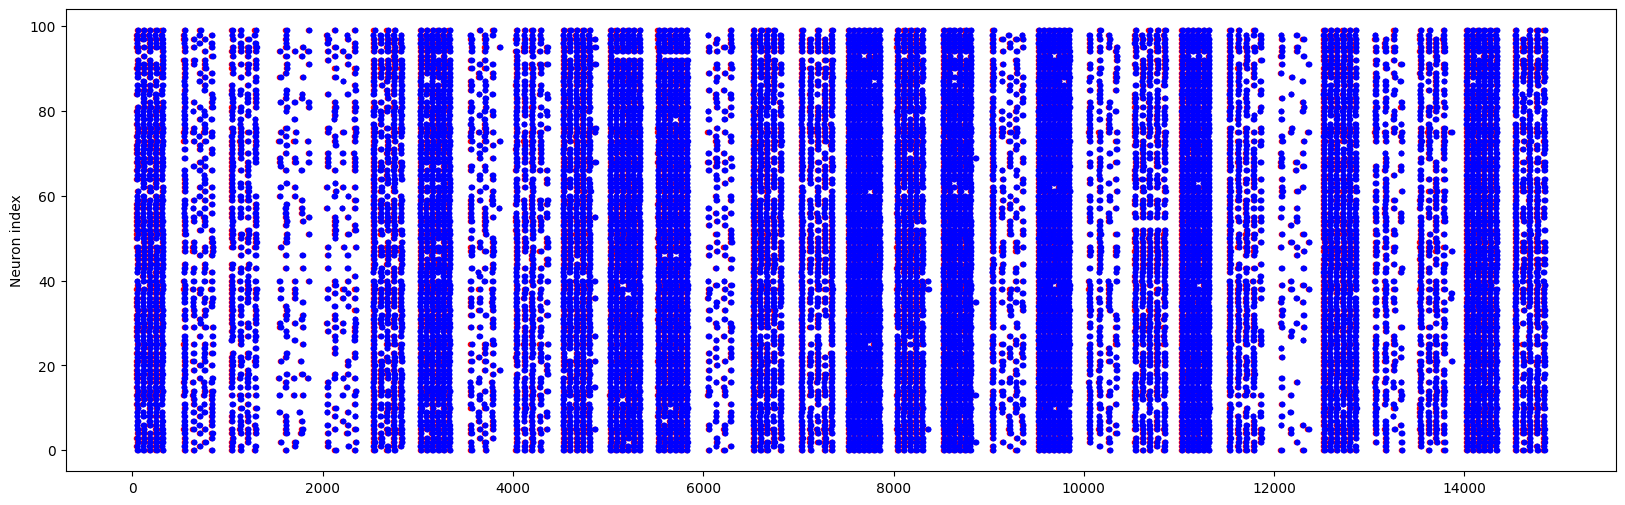

In [41]:
def plot_w(S1M):
    plt.rcParams["figure.figsize"] = (20,10)
    subplot(311)
    plot(S1M.t/ms, S1M.w.T/gmax)
    ylabel('w / wmax')
    subplot(312)
    plot(S1M.t/ms, S1M.Apre.T)
    ylabel('apre')
    subplot(313)
    plot(S1M.t/ms, S1M.Apost.T)
    ylabel('apost')
    tight_layout()
    show();
    
def plot_v(ESM, ISM, neuron=13):
    plt.rcParams["figure.figsize"] = (20,6)
    cnt = -50000 # tail
    plot(ESM.t[cnt:]/ms, ESM.v[neuron][cnt:]/mV, label='exc', color='r')
    plot(ISM.t[cnt:]/ms, ISM.v[neuron][cnt:]/mV, label='inh', color='b')
    plt.axhline(y=v_thresh_e/mV, color='pink', label='v_thresh_e')
    plt.axhline(y=v_thresh_i/mV, color='silver', label='v_thresh_i')
    legend()
    ylabel('v')
    show();
    
def plot_rates(ERM, IRM):
    plt.rcParams["figure.figsize"] = (20,6)
    plot(ERM.t/ms, ERM.smooth_rate(window='flat', width=0.1*ms)*Hz, color='r')
    plot(IRM.t/ms, IRM.smooth_rate(window='flat', width=0.1*ms)*Hz, color='b')
    ylabel('Rate')
    show();
    
def plot_spikes(ESP, ISP):
    plt.rcParams["figure.figsize"] = (20,6)
    plot(ESP.t/ms, ESP.i, '.r')
    plot(ISP.t/ms, ISP.i, '.b')
    ylabel('Neuron index')
    show();

def test0(train_items=30):
    '''
    STDP visualisation
    '''
    seed(0)
    
    model = Model(debug=True)
    model.train(X_train[:train_items], epoch=1)
    
    plot_w(model['S1M'])
    plot_v(model['ESM'], model['ISM'])
    plot_rates(model['ERM'], model['IRM'])
    plot_spikes(model['ESP'], model['ISP'])
    
test0()

In [42]:
def test1(train_items=5000, assign_items=1000, eval_items=1000):
    '''
    Feed train set to SNN with STDP
    Freeze STDP
    Feed train set to SNN again and collect generated features
    Train RandomForest on the top of these features and labels provided
    Feed test set to SNN and collect new features
    Predict labels with RandomForest and calculate accuacy score
    '''
    seed(0)
    
    model = Model()
    model.train(X_train[:train_items], epoch=1)
    model.net.store('train', 'train.b2')
    #model.net.restore('train', './train.b2')
    
    f_train = model.evaluate(X_train[:assign_items])
    clf = RandomForestClassifier(max_depth=4, random_state=0)
    clf.fit(f_train, y_train[:assign_items])
    print(clf.score(f_train, y_train[:assign_items]))

    f_test = model.evaluate(X_test[:eval_items])
    y_pred = clf.predict(f_test)
    print(accuracy_score(y_pred, y_test[:eval_items]))

    cm = confusion_matrix(y_pred, y_test[:eval_items])
    print(cm)
    
test1()

0.935
0.907
[[299   0  35]
 [  0 368  43]
 [  5  10 240]]


In [43]:
def test2(train_items=5000, assign_items=1000, eval_items=1000):
    '''
    Freeze STDP at start
    Feed train set to SNN and collect generated features
    Train RandomForest on the top of these features and labels provided
    Feed test set to SNN and collect new features
    Predict labels with RandomForest and calculate accuacy score
    '''
    seed(0)
    
    model = Model()
        
    f_train = model.evaluate(X_train[:assign_items])
    clf = RandomForestClassifier(max_depth=4, random_state=0)
    clf.fit(f_train, y_train[:assign_items])
    print(clf.score(f_train, y_train[:assign_items]))

    f_test = model.evaluate(X_test[:eval_items])
    y_pred = clf.predict(f_test)
    print(accuracy_score(y_pred, y_test[:eval_items]))

    cm = confusion_matrix(y_pred, y_test[:eval_items])
    print(cm)
    
test2()

0.849
0.787
[[216   2  72]
 [ 10 359  34]
 [ 78  17 212]]


In [44]:
def test3(train_items=5000, eval_items=1000):
    '''
    Train and evaluate RandomForest without SNN
    '''
    seed(0)
    
    clf = RandomForestClassifier(max_depth=4, random_state=0)
    
    train_features = X_train[:train_items].reshape(-1,28*28)
    clf.fit(train_features, y_train[:train_items])
    print(clf.score(train_features, y_train[:train_items]))
    
    test_features = X_test[:eval_items].reshape(-1,28*28)
    y_pred = clf.predict(test_features)
    print(accuracy_score(y_pred, y_test[:eval_items]))

    cm = confusion_matrix(y_pred, y_test[:eval_items])
    print(cm)
    
test3()

0.973
0.984
[[303   0   4]
 [  0 370   3]
 [  1   8 311]]
